In [1]:
!pip install pyaurn

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import requests
import pyaurn
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 15]
import os

from concurrent.futures import ThreadPoolExecutor, wait
#from google.colab import drive
from shutil import make_archive, move
from math import sin, cos
from IPython.display import clear_output

In [3]:
metadata = pyaurn.importMeta().set_index("site_id")

In [4]:
display(metadata)
filtered_metadata = metadata.drop(["site_name", "parameter", "Parameter_name", "start_date", "end_date", "ratified_to", "zone", "agglomeration", "local_authority"], axis=1)

,site_name,location_type,latitude,longitude,parameter,Parameter_name,start_date,end_date,ratified_to,zone,agglomeration,local_authority
site_id,,,,,,,,,,,,
ABD,Aberdeen,Urban Background,57.157360,-2.094278,O3,Ozone,2003-08-01,2021-09-20,2021-09-20,North East Scotland,NaN,Aberdeen City
ABD9,Aberdeen Erroll Park,Urban Background,57.157400,-2.094770,O3,Ozone,2021-10-01,ongoing,2022-09-30,North East Scotland,NaN,Aberdeen City
ABD7,Aberdeen Union Street Roadside,Urban Traffic,57.144555,-2.106472,NO,Nitric oxide,2008-01-01,ongoing,2022-09-30,North East Scotland,NaN,Aberdeen City
ABD8,Aberdeen Wellington Road,Urban Traffic,57.133888,-2.094198,NO,Nitric oxide,2016-02-09,ongoing,2022-09-30,North East Scotland,NaN,Aberdeen City
ARM6,Armagh Roadside,Urban Traffic,54.353728,-6.654558,NO,Nitric oxide,2009-01-01,ongoing,2022-09-30,Northern Ireland,NaN,Armagh
...,...,...,...,...,...,...,...,...,...,...,...,...
WRAY,Wray,Rural Background,54.104666,-2.584182,O3,Ozone,1985-04-01,1988-02-29,1988-02-29,North West & Merseyside,NaN,Lancaster
WREX,Wrexham,Urban Traffic,53.042282,-3.002829,NO,Nitric oxide,2002-03-06,ongoing,2022-09-30,North Wales,NaN,Wrexham
YW,Yarner Wood,Rural Background,50.597600,-3.716510,O3,Ozone,1987-06-26,ongoing,2022-09-30,South West,NaN,Teignbridge


In [5]:
def get_site_data(name, year_range):
  try:
    data = pyaurn.importAURN(name, year_range).reset_index()
    data["site_id"] = name
    data["day"] = data["date"].dt.day
    data["month"] = data["date"].dt.month
    data["year"] = data["date"].dt.year
    data["hour"] = data["date"].dt.hour
    if "PM2.5" in data.columns:
      data = data[["day", "month", "year", "hour", "PM2.5", "site_id"]]
      data = data.dropna()
      data = data.merge(filtered_metadata, on="site_id").drop("site_id", axis=1)
      return data
  except KeyError:
    return

In [6]:
display(metadata.index)
with ThreadPoolExecutor(min(32, os.cpu_count() + 4)) as executor:
  all_data = [executor.submit(get_site_data, name, range(2021, 2022)) for name in metadata.index]
  all_data = wait(all_data)
  clear_output()

In [7]:
retrieved_data = [item.result() for item in all_data.done]
display(retrieved_data[0])
concatenated_data = pd.concat(retrieved_data, ignore_index=True)
display(concatenated_data)

None

,day,month,year,hour,PM2.5,location_type,latitude,longitude
0,1,1,2021,0,28.0,Urban Traffic,51.074793,-4.041924
1,1,1,2021,1,18.0,Urban Traffic,51.074793,-4.041924
2,1,1,2021,2,20.0,Urban Traffic,51.074793,-4.041924
3,1,1,2021,3,20.0,Urban Traffic,51.074793,-4.041924
4,1,1,2021,4,15.0,Urban Traffic,51.074793,-4.041924
...,...,...,...,...,...,...,...,...
656745,31,12,2021,19,14.0,Urban Background,53.967513,-1.086514
656746,31,12,2021,20,14.0,Urban Background,53.967513,-1.086514
656747,31,12,2021,21,13.0,Urban Background,53.967513,-1.086514
656748,31,12,2021,22,12.0,Urban Background,53.967513,-1.086514


In [8]:
dataset_length = len(concatenated_data)

#train_dataset = concatenated_data[0:int(0.7*dataset_length)]
#val_dataset = concatenated_data[int(0.7*dataset_length):int(0.9*dataset_length)]
#test_dataset = concatenated_data[int(0.9*dataset_length):]

train_dataset = concatenated_data.sample(frac=0.7)
val_dataset = concatenated_data.drop(train_dataset.index).sample(frac=0.66)
test_dataset = concatenated_data.drop(train_dataset.index).drop(val_dataset.index)
display(train_dataset)
display(val_dataset)
display(test_dataset)

,day,month,year,hour,PM2.5,location_type,latitude,longitude
112469,22,12,2021,7,20.800,Urban Traffic,53.951889,-1.075861
17694,31,3,2021,5,7.972,Urban Background,55.945589,-3.182186
53663,20,2,2021,1,5.873,Urban Background,53.244131,-1.454946
37240,15,7,2021,14,5.708,Urban Background,52.481346,-1.918235
391134,10,10,2021,8,24.410,Urban Background,51.425286,-0.345606
...,...,...,...,...,...,...,...,...
333375,7,10,2021,13,5.307,Urban Background,53.748780,-0.341222
505904,27,3,2021,19,4.000,Urban Traffic,54.516667,-1.358547
194760,29,7,2021,18,4.741,Urban Background,50.371670,-4.142361
462547,9,3,2021,1,27.000,Urban Background,51.494670,-0.131931


,day,month,year,hour,PM2.5,location_type,latitude,longitude
332240,21,8,2021,6,5.637,Urban Background,53.748780,-0.341222
330120,24,5,2021,21,3.726,Urban Background,53.748780,-0.341222
72490,30,4,2021,23,1.533,Urban Traffic,55.944079,-4.734421
560513,10,4,2021,10,3.538,Urban Background,51.544166,0.678331
396612,26,5,2021,21,5.684,Urban Traffic,53.042282,-3.002829
...,...,...,...,...,...,...,...,...
226623,7,5,2021,17,2.642,Urban Background,52.411628,-1.560189
231065,11,11,2021,9,5.684,Urban Background,52.411628,-1.560189
115137,14,4,2021,12,16.344,Rural Background,51.149617,-1.438228
103974,12,12,2021,7,2.783,Rural Background,51.782616,-4.692370


,day,month,year,hour,PM2.5,location_type,latitude,longitude
0,1,1,2021,0,28.0,Urban Traffic,51.074793,-4.041924
14,1,1,2021,14,21.0,Urban Traffic,51.074793,-4.041924
19,1,1,2021,19,38.0,Urban Traffic,51.074793,-4.041924
20,1,1,2021,20,35.0,Urban Traffic,51.074793,-4.041924
21,1,1,2021,21,31.0,Urban Traffic,51.074793,-4.041924
...,...,...,...,...,...,...,...,...
656693,25,12,2021,0,5.0,Urban Background,53.967513,-1.086514
656724,30,12,2021,22,-2.0,Urban Background,53.967513,-1.086514
656727,31,12,2021,1,5.0,Urban Background,53.967513,-1.086514
656734,31,12,2021,8,4.0,Urban Background,53.967513,-1.086514


In [9]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("PM2.5")
val_labels = val_features.pop("PM2.5")
test_labels = test_features.pop("PM2.5")

train_features.shape

(459725, 7)

In [10]:
def split_data_for_preprocessing(dataset):
  text_cols = ["location_type"]
  number_cols = ["day", "month", "year", "hour", "latitude", "longitude"]

  return (dataset[number_cols], dataset[text_cols])

In [11]:
train_features_split = split_data_for_preprocessing(train_features)
val_features_split = split_data_for_preprocessing(val_features)
test_features_split = split_data_for_preprocessing(test_features)

print(train_features_split[0].info())
print(train_features_split[1].info())
print(pd.unique(train_features_split[1]["location_type"]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459725 entries, 112469 to 562149
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   day        459725 non-null  int64  
 1   month      459725 non-null  int64  
 2   year       459725 non-null  int64  
 3   hour       459725 non-null  int64  
 4   latitude   459725 non-null  float64
 5   longitude  459725 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 24.6 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 459725 entries, 112469 to 562149
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   location_type  459725 non-null  object
dtypes: object(1)
memory usage: 7.0+ MB
None
['Urban Traffic' 'Urban Background' 'Rural Background'
 'Suburban Background' 'Urban Industrial']


In [12]:
vocabulary = np.array(pd.unique(train_features["location_type"]))
category_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="category_inputs")
lookup_layer = tf.keras.layers.StringLookup(vocabulary=vocabulary, output_mode="multi_hot")(category_inputs)

numeric_inputs = tf.keras.layers.Input(shape=(6,), name="numeric_inputs")
normalisation_layer = tf.keras.layers.Normalization()
normalisation_layer.adapt(train_features_split[0])
normalisation_layer = normalisation_layer(numeric_inputs)

concatenated_inputs = tf.keras.layers.concatenate([lookup_layer, normalisation_layer])
dense_layer = tf.keras.layers.Dense(32, activation="tanh")(concatenated_inputs)
outputs = tf.keras.layers.Dense(1)(dense_layer)

model = tf.keras.Model(inputs=[category_inputs, numeric_inputs], outputs=outputs)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
category_inputs (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
numeric_inputs (InputLayer)     [(None, 6)]          0                                            
__________________________________________________________________________________________________
string_lookup (StringLookup)    (None, 6)            0           category_inputs[0][0]            
__________________________________________________________________________________________________
normalization (Normalization)   (None, 6)            13          numeric_inputs[0][0]             
______________________________________________________________________________________________

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss="mean_squared_error",
    metrics = ["mean_absolute_error"]
)

In [14]:
print(train_features.dtypes)
history = model.fit(
    (train_features_split[1], train_features_split[0]),
    train_labels,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.001),
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

    ],
    validation_data = ((val_features_split[1], val_features_split[0]), val_labels)
)

day                int64
month              int64
year               int64
hour               int64
location_type     object
latitude         float64
longitude        float64
dtype: object
Epoch 1/10
14367/14367 [==============================] - 77s 5ms/step - loss: 39.9289 - mean_absolute_error: 4.3000 - val_loss: 36.0315 - val_mean_absolute_error: 4.1032
Epoch 2/10
14367/14367 [==============================] - 83s 6ms/step - loss: 37.5674 - mean_absolute_error: 4.1789 - val_loss: 36.6199 - val_mean_absolute_error: 4.1154
Epoch 3/10
14367/14367 [==============================] - 83s 6ms/step - loss: 34.3643 - mean_absolute_error: 3.9579 - val_loss: 33.5104 - val_mean_absolute_error: 3.8439
Epoch 4/10
14367/14367 [==============================] - 83s 6ms/step - loss: 33.9646 - mean_absolute_error: 3.9344 - val_loss: 33.4925 - val_mean_absolute_error: 3.8124
Epoch 5/10
14367/14367 [==============================] - 83s 6ms/step - loss: 33.7704 - mean_absolute_error: 3.9210 - val_loss

{'loss': [39.92888259887695,
  37.56740188598633,
  34.36429214477539,
  33.96464538574219,
  33.7703857421875,
  33.63172912597656,
  33.5732421875,
  33.04314041137695,
  33.00212478637695,
  32.99794387817383],
 'mean_absolute_error': [4.2999958992004395,
  4.1788716316223145,
  3.9578819274902344,
  3.934359073638916,
  3.9209907054901123,
  3.913435459136963,
  3.9116344451904297,
  3.8697993755340576,
  3.8675665855407715,
  3.868375301361084],
 'val_loss': [36.031463623046875,
  36.61988830566406,
  33.51040267944336,
  33.49246597290039,
  33.11471176147461,
  32.95071029663086,
  33.26864242553711,
  32.46671676635742,
  32.44062042236328,
  32.48582077026367],
 'val_mean_absolute_error': [4.103211402893066,
  4.115449905395508,
  3.843853235244751,
  3.8124313354492188,
  3.964341402053833,
  3.8531503677368164,
  3.8812386989593506,
  3.8645405769348145,
  3.8590643405914307,
  3.862337350845337],
 'lr': [0.1,
  0.1,
  0.02,
  0.02,
  0.02,
  0.02,
  0.02,
  0.0039999997,
  

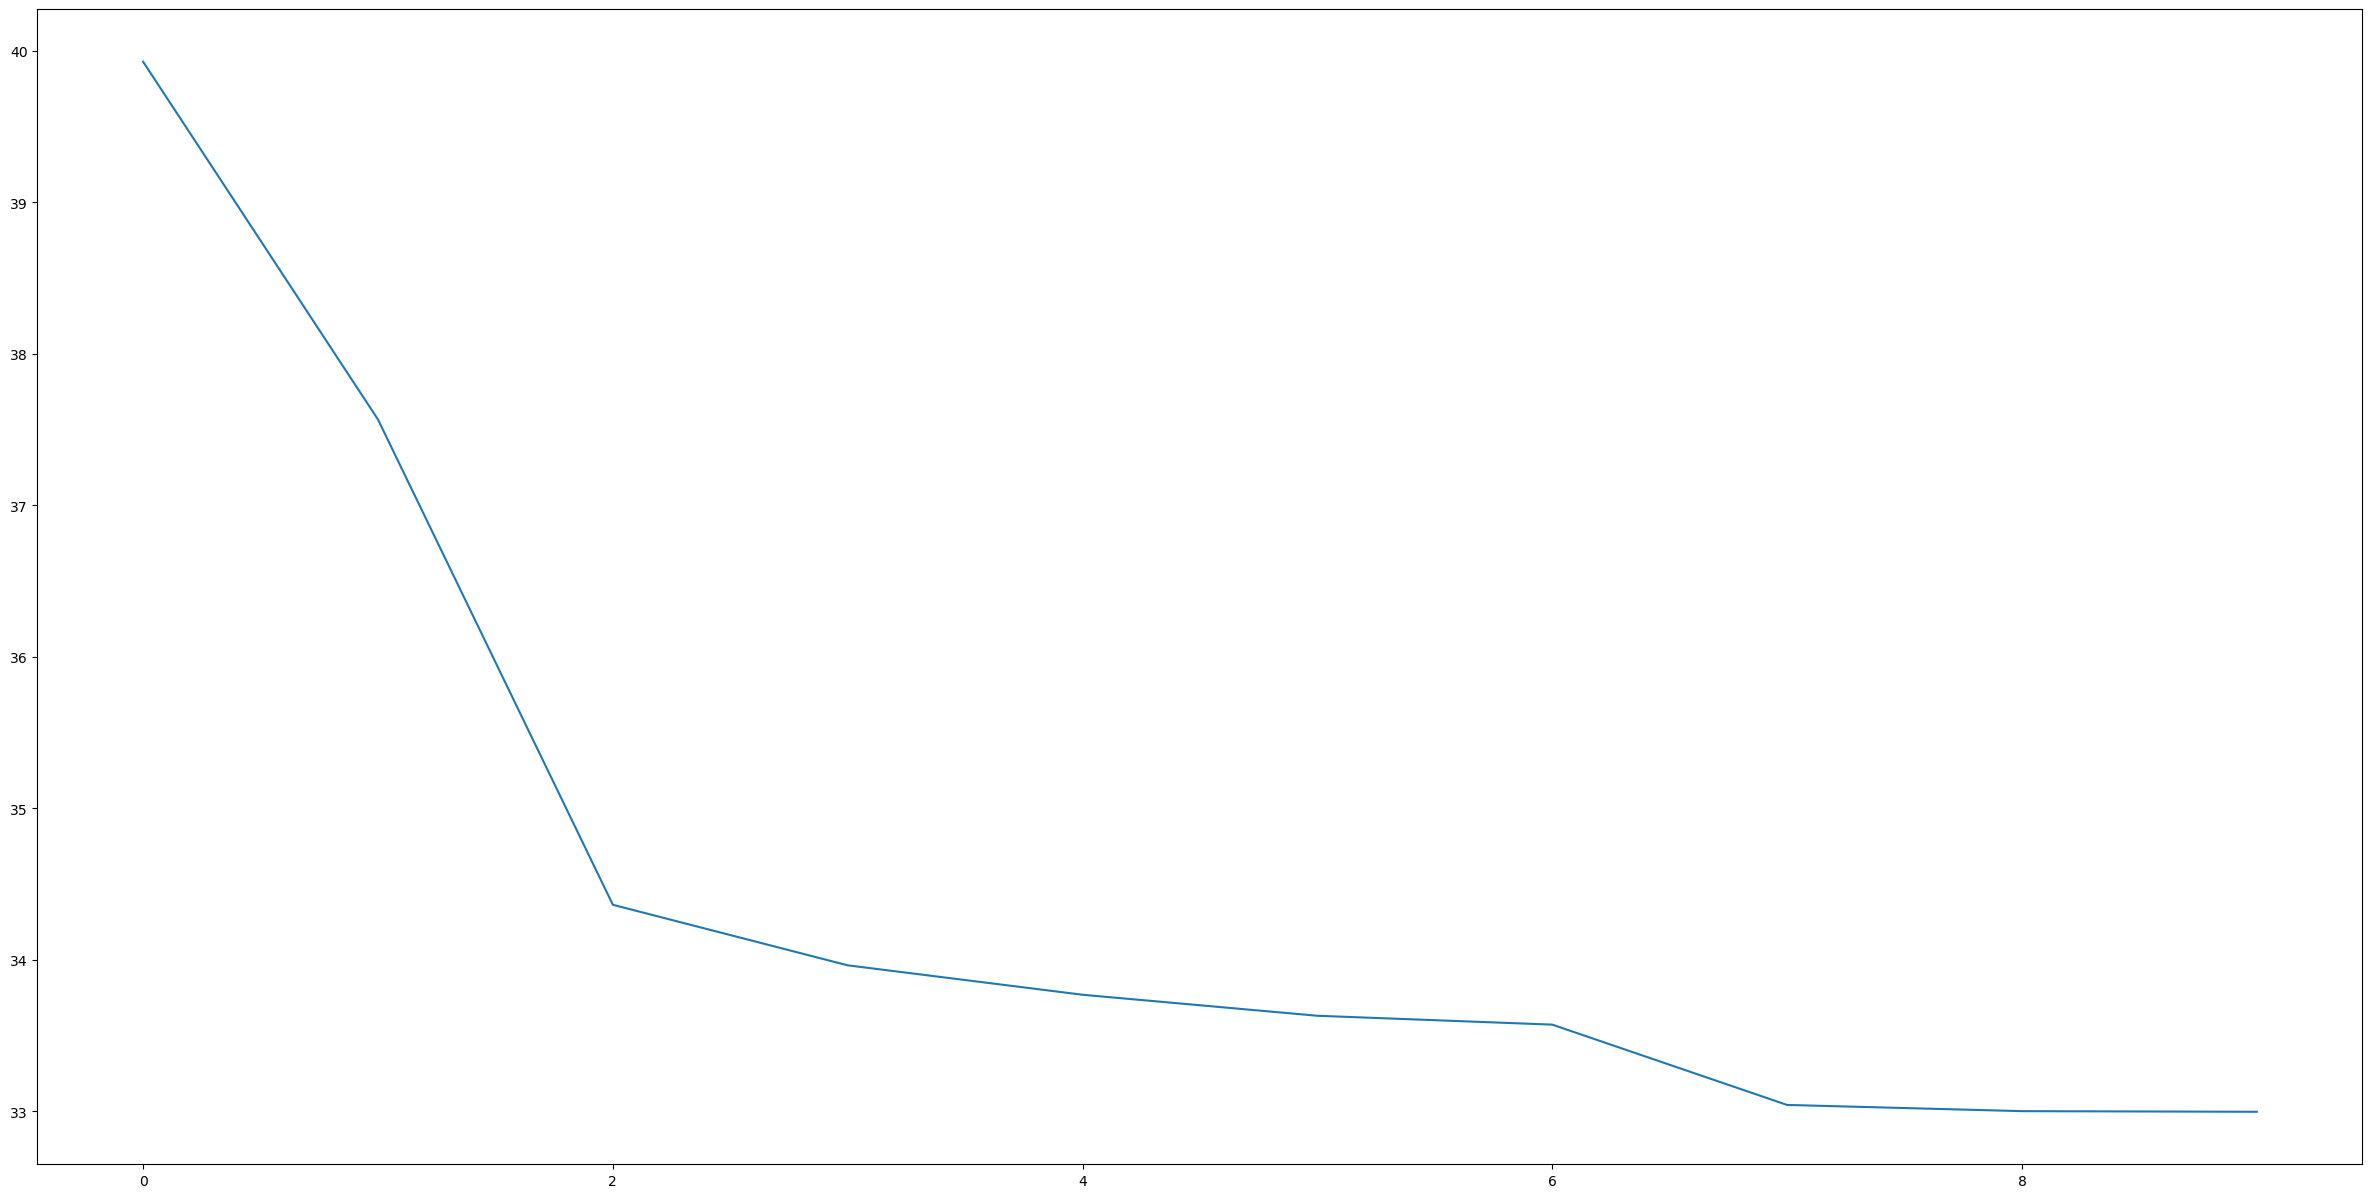

In [15]:
display(history.history)
plt.plot(history.history["loss"])
plt.show()

array([11.297014 , 11.520521 , 13.202576 , ...,  6.409876 ,  6.0116825,
        8.075874 ], dtype=float32)

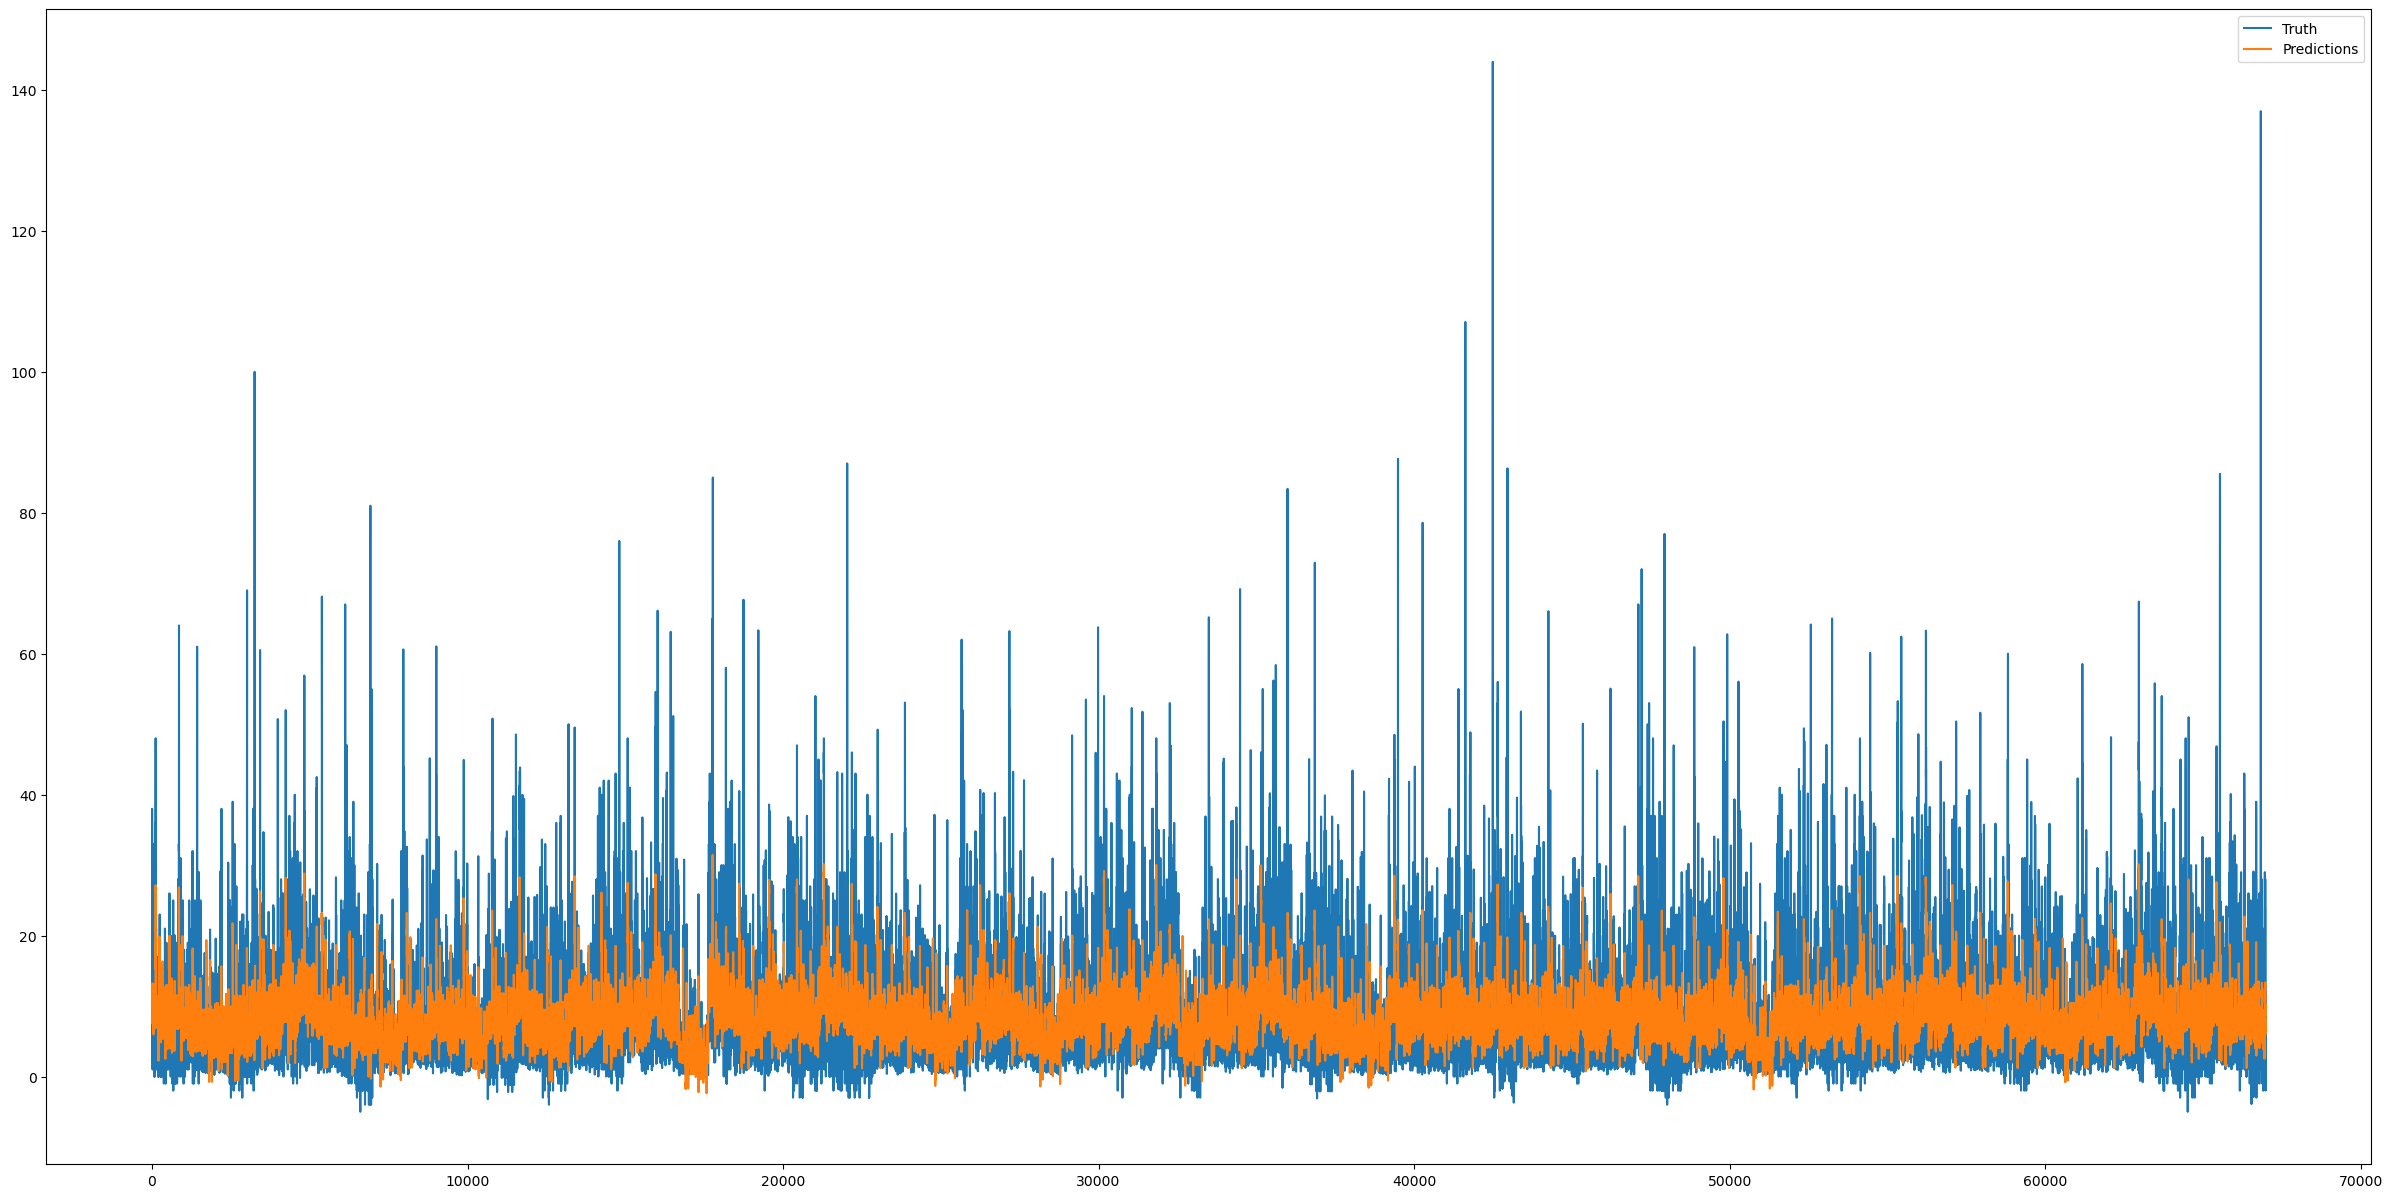

In [16]:
predictions = model.predict([test_features_split[1], test_features_split[0]]).flatten()
display(predictions)
plt.plot(test_labels.reset_index(drop=True), label="Truth")
plt.plot(predictions, label="Predictions")
plt.legend()

In [17]:
#drive.mount("/content/gdrive", force_remount=True)
model.save("/content/comp3000model")
zip_location = make_archive("model", "zip", "/content/comp3000model")
#move(zip_location, "/content/gdrive/MyDrive/comp3000model/model.zip")
#drive.flush_and_unmount()

INFO:tensorflow:Assets written to: /content/comp3000model\assets
